# Libs, cuda, seed, params

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from torch.nn.utils import clip_grad_norm_

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.01
BATCH_SIZE = 1
N_EPOCHS = 400
IMG_SIZE = 32

# Data

In [7]:
def convert_img_to_gray(image, path=None):
    imgGray = image.convert('L')
    if path:
        imgGray.save(path)
    return imgGray

def get_data(img_in_path, img_out_path):
    img_in = Image.open(img_in_path+".jpg")
    img_out = Image.open(img_out_path+".jpg")
    img_in = convert_img_to_gray(img_in, img_in_path+"_bw.jpg")
    img_out = convert_img_to_gray(img_out, img_out_path+"_bw.jpg")
    
    transform = T.Compose(transforms=[
        T.ToPILImage(),
        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
        T.ToTensor()
    ])
    
    img_in = transform(read_image(img_in_path+"_bw.jpg"))
    img_out = transform(read_image(img_out_path+"_bw.jpg"))
    
    return img_in, img_out

In [9]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [8]:
im_in_path = 'images/only_trans/one_bottom_little'
im_out_path = 'images/only_trans/one_center'
im_in, im_out = get_data(img_in_path=im_in_path, img_out_path=im_out_path)

In [10]:
train_loader = DataLoader(dataset=CustomTestDataset(im_in, im_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

# Transform functions

In [11]:
def get_transform_matrix(theta, scale_factor, trans_x, trans_y, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), trans_x, scale_factor * theta_sin, scale_factor*theta_cos, trans_y]).view(2,3)


def transform_img(x, theta, scale_factor, trans_x, trans_y, device):
    scale_mat = get_transform_matrix(theta = theta, scale_factor=scale_factor, trans_x=trans_x, trans_y=trans_y,device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x


def transform_img_with_matrix(x, trans_matrix):
    scale_mat = trans_matrix.view(2,3).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

# Network

+ Functions

In [12]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [13]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=50):
    best_loss = 1e10
    train_losses = []
 
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')
    
    return model, optimizer, train_losses

+ Model

In [14]:
class AttentionTransformation(nn.Module):

    def __init__(self, device, img_size):
        super().__init__()
        
        self.device = device
        self.img_size = img_size
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=6, out_channels=3, kernel_size=2, stride=2),
            
        )
        
        self.transf_ff = nn.Sequential(
            nn.Linear(in_features=108, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=4)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
        )
        
        self.rot_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1)
        )
        
        self.trans_x_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        ) 
            
        self.trans_y_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        )
        
        # zeroing transformation weights
        with torch.no_grad():
            self.transf_ff[0].weight.data.zero_()
            self.transf_ff[2].weight.data.zero_()            
            self.scale_ff[0].weight.data.zero_()            
            self.rot_ff[0].weight.data.zero_()            
            self.trans_x_ff[0].weight.data.zero_()                       
            self.trans_y_ff[0].weight.data.zero_()


    def forward(self, x_inp, is_evaling=False):
        x = self.feature_extractor(x_inp)
        x = torch.flatten(x, 1)
        trans = self.transf_ff(x)
        trans_x = self.trans_x_ff(trans)
        trans_y = self.trans_y_ff(trans)
        scale_factor = torch.exp(self.scale_ff(trans))
        rot_factor = self.rot_ff(trans)
        if is_evaling:
            print("Params:\n-Scale: " + str(scale_factor)+ "\n-Theta: " + str(rot_factor)+"\n-Trans_x: " + str(trans_x)+"\n-Trans_y: " + str(trans_y))
        trans_x =transform_img(x=x_inp, theta=rot_factor, scale_factor=scale_factor, device=self.device, trans_x=trans_x, trans_y=trans_y)
        return trans_x

In [18]:
torch.manual_seed(RANDOM_SEED)
model = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss(reduction="mean")

In [19]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, N_EPOCHS, device, print_every=30)

11:19:00 --- Epoch: 29	Train loss: 0.0035
11:19:01 --- Epoch: 59	Train loss: 0.0001
11:19:01 --- Epoch: 89	Train loss: 0.0001
11:19:01 --- Epoch: 119	Train loss: 0.0001
11:19:02 --- Epoch: 149	Train loss: 0.0001
11:19:02 --- Epoch: 179	Train loss: 0.0001
11:19:03 --- Epoch: 209	Train loss: 0.0001
11:19:03 --- Epoch: 239	Train loss: 0.0001
11:19:03 --- Epoch: 269	Train loss: 0.0001
11:19:04 --- Epoch: 299	Train loss: 0.0001
11:19:04 --- Epoch: 329	Train loss: 0.0001
11:19:04 --- Epoch: 359	Train loss: 0.0001
11:19:05 --- Epoch: 389	Train loss: 0.0001


# Evaluation

In [22]:
def evaluate_model(model, train_loader, device):
  img_inp, img_out = next(iter(train_loader))
  
  print("Proposed transformation", end=" ")
  with torch.no_grad():
    y = model(img_inp.to(device),is_evaling=True)
  
  print(f"Shape of prediction: {y.shape}")
  
  print(f"Images:")
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  ax[0].title.set_text("Input")
  ax[0].imshow(img_inp.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  ax[1].title.set_text("Prediction")
  ax[1].imshow(y.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  ax[2].title.set_text("Target")
  ax[2].imshow(img_out.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  plt.show()

Proposed transformation Params:
-Scale: tensor([[1.0011]], device='cuda:0')
-Theta: tensor([[-7.4506e-08]], device='cuda:0')
-Trans_x: tensor([[1.8626e-08]], device='cuda:0')
-Trans_y: tensor([[0.1254]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


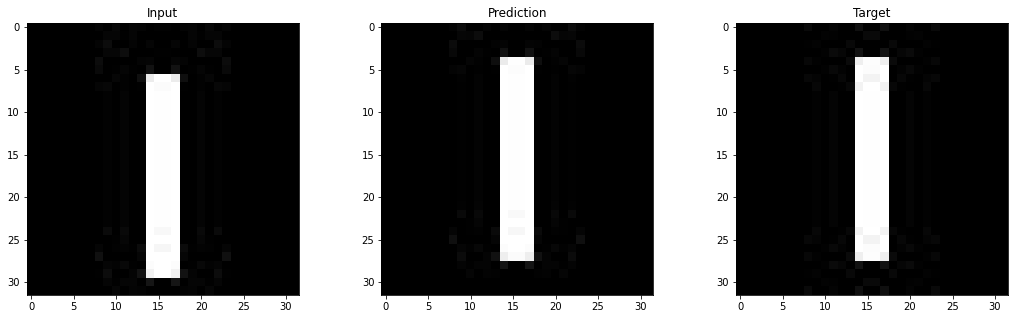

In [23]:
evaluate_model(model, train_loader, device)

# More examples:

In [27]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.01
BATCH_SIZE = 1
N_EPOCHS = 400
IMG_SIZE = 32

im2_in_path = 'images/only_trans/one_another_weird'
im2_out_path = 'images/only_trans/one_center'
im2_in, im2_out = get_data(img_in_path=im2_in_path, img_out_path=im2_out_path)

train_loader2 = DataLoader(dataset=CustomTestDataset(im2_in, im2_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [28]:
torch.manual_seed(RANDOM_SEED)
model2 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)
criterion2 = nn.MSELoss(reduction="mean")

model2, optimizer2, _ = training_loop(model2, criterion2, optimizer2, train_loader2, N_EPOCHS, device, print_every=30)

11:24:14 --- Epoch: 29	Train loss: 0.0355
11:24:15 --- Epoch: 59	Train loss: 0.0262
11:24:15 --- Epoch: 89	Train loss: 0.0168
11:24:15 --- Epoch: 119	Train loss: 0.0168
11:24:16 --- Epoch: 149	Train loss: 0.0168
11:24:16 --- Epoch: 179	Train loss: 0.0168
11:24:17 --- Epoch: 209	Train loss: 0.0168
11:24:17 --- Epoch: 239	Train loss: 0.0168
11:24:17 --- Epoch: 269	Train loss: 0.0168
11:24:18 --- Epoch: 299	Train loss: 0.0168
11:24:18 --- Epoch: 329	Train loss: 0.0168
11:24:18 --- Epoch: 359	Train loss: 0.0168
11:24:19 --- Epoch: 389	Train loss: 0.0168


Proposed transformation Params:
-Scale: tensor([[0.5568]], device='cuda:0')
-Theta: tensor([[9.9689e-06]], device='cuda:0')
-Trans_x: tensor([[-0.1249]], device='cuda:0')
-Trans_y: tensor([[0.0107]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


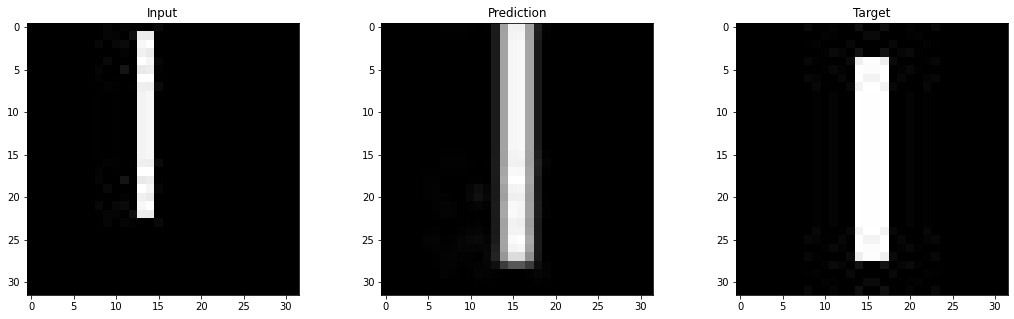

In [29]:
evaluate_model(model2, train_loader2, device)

In [42]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im3_in_path = 'images/only_trans/one_center'
im3_out_path = 'images/only_trans/one_another_weird'
im3_in, im3_out = get_data(img_in_path=im3_in_path, img_out_path=im3_out_path)

train_loader3 = DataLoader(dataset=CustomTestDataset(im3_in, im3_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [43]:
torch.manual_seed(RANDOM_SEED)
model3 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)
criterion3 = nn.MSELoss(reduction="mean")

model3, optimizer3, _ = training_loop(model3, criterion3, optimizer3, train_loader3, N_EPOCHS, device, print_every=30)

11:27:09 --- Epoch: 29	Train loss: 0.1001
11:27:09 --- Epoch: 59	Train loss: 0.0991
11:27:09 --- Epoch: 89	Train loss: 0.0968
11:27:10 --- Epoch: 119	Train loss: 0.0940
11:27:10 --- Epoch: 149	Train loss: 0.0866
11:27:11 --- Epoch: 179	Train loss: 0.0736
11:27:11 --- Epoch: 209	Train loss: 0.0613
11:27:11 --- Epoch: 239	Train loss: 0.0552
11:27:12 --- Epoch: 269	Train loss: 0.0498
11:27:12 --- Epoch: 299	Train loss: 0.0436
11:27:13 --- Epoch: 329	Train loss: 0.0391
11:27:13 --- Epoch: 359	Train loss: 0.0331
11:27:13 --- Epoch: 389	Train loss: 0.0280
11:27:14 --- Epoch: 419	Train loss: 0.0229
11:27:14 --- Epoch: 449	Train loss: 0.0180
11:27:14 --- Epoch: 479	Train loss: 0.0178
11:27:15 --- Epoch: 509	Train loss: 0.0162
11:27:15 --- Epoch: 539	Train loss: 0.0160
11:27:15 --- Epoch: 569	Train loss: 0.0145
11:27:16 --- Epoch: 599	Train loss: 0.0142
11:27:16 --- Epoch: 629	Train loss: 0.0138
11:27:16 --- Epoch: 659	Train loss: 0.0125
11:27:17 --- Epoch: 689	Train loss: 0.0124
11:27:17 --- E

Proposed transformation Params:
-Scale: tensor([[1.6456]], device='cuda:0')
-Theta: tensor([[-0.0002]], device='cuda:0')
-Trans_x: tensor([[0.2057]], device='cuda:0')
-Trans_y: tensor([[0.0569]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


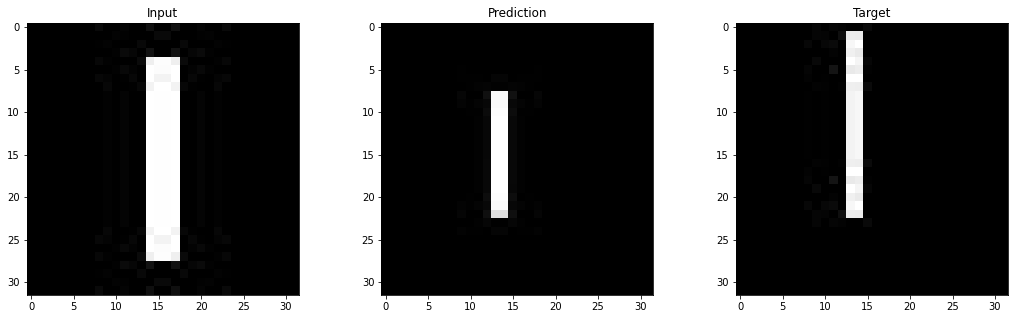

In [44]:
evaluate_model(model3, train_loader3, device)

In [46]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im4_in_path = 'images/sc_rot_tr/third3'
im4_out_path = 'images/sc_rot_tr/sec2'
im4_in, im4_out = get_data(img_in_path=im4_in_path, img_out_path=im4_out_path)

train_loader4 = DataLoader(dataset=CustomTestDataset(im4_in, im4_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [49]:
torch.manual_seed(RANDOM_SEED)
model4 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)
criterion4 = nn.MSELoss(reduction="mean")

model4, optimizer4, _ = training_loop(model4, criterion4, optimizer4, train_loader4, N_EPOCHS, device, print_every=30)

11:31:10 --- Epoch: 29	Train loss: 0.0781
11:31:11 --- Epoch: 59	Train loss: 0.0780
11:31:11 --- Epoch: 89	Train loss: 0.0778
11:31:11 --- Epoch: 119	Train loss: 0.0774
11:31:12 --- Epoch: 149	Train loss: 0.0768
11:31:12 --- Epoch: 179	Train loss: 0.0763
11:31:12 --- Epoch: 209	Train loss: 0.0750
11:31:13 --- Epoch: 239	Train loss: 0.0719
11:31:13 --- Epoch: 269	Train loss: 0.0670
11:31:13 --- Epoch: 299	Train loss: 0.0637
11:31:14 --- Epoch: 329	Train loss: 0.0599
11:31:14 --- Epoch: 359	Train loss: 0.0548
11:31:14 --- Epoch: 389	Train loss: 0.0497
11:31:15 --- Epoch: 419	Train loss: 0.0448
11:31:15 --- Epoch: 449	Train loss: 0.0401
11:31:15 --- Epoch: 479	Train loss: 0.0348
11:31:16 --- Epoch: 509	Train loss: 0.0296
11:31:16 --- Epoch: 539	Train loss: 0.0243
11:31:17 --- Epoch: 569	Train loss: 0.0186
11:31:17 --- Epoch: 599	Train loss: 0.0139
11:31:17 --- Epoch: 629	Train loss: 0.0132
11:31:18 --- Epoch: 659	Train loss: 0.0132
11:31:18 --- Epoch: 689	Train loss: 0.0132
11:31:18 --- E

Proposed transformation Params:
-Scale: tensor([[0.5683]], device='cuda:0')
-Theta: tensor([[0.7135]], device='cuda:0')
-Trans_x: tensor([[-0.1911]], device='cuda:0')
-Trans_y: tensor([[-0.3010]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


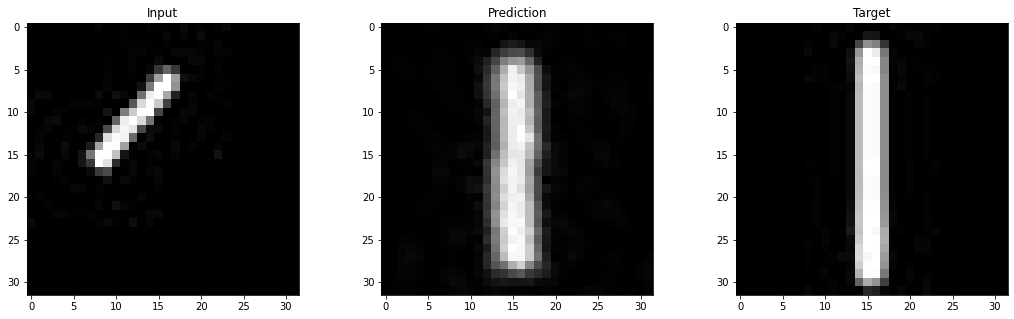

In [51]:
evaluate_model(model4, train_loader4, device)

In [52]:
# parameters
RANDOM_SEED = 420
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im5_in_path = 'images/sc_rot_tr/zero_tf'
im5_out_path = 'images/sc_rot_tr/'
im5_in, im5_out = get_data(img_in_path=im5_in_path, img_out_path=im5_out_path)

train_loader5 = DataLoader(dataset=CustomTestDataset(im5_in, im5_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [53]:
torch.manual_seed(RANDOM_SEED)
model5 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=LEARNING_RATE)
criterion5 = nn.MSELoss(reduction="mean")

model5, optimizer5, _ = training_loop(model5, criterion5, optimizer5, train_loader5, N_EPOCHS, device, print_every=30)

11:45:16 --- Epoch: 29	Train loss: 0.1368
11:45:16 --- Epoch: 59	Train loss: 0.1355
11:45:16 --- Epoch: 89	Train loss: 0.1336
11:45:17 --- Epoch: 119	Train loss: 0.1304
11:45:17 --- Epoch: 149	Train loss: 0.1233
11:45:17 --- Epoch: 179	Train loss: 0.1195
11:45:18 --- Epoch: 209	Train loss: 0.1188
11:45:18 --- Epoch: 239	Train loss: 0.1180
11:45:18 --- Epoch: 269	Train loss: 0.1170
11:45:19 --- Epoch: 299	Train loss: 0.1156
11:45:19 --- Epoch: 329	Train loss: 0.1144
11:45:20 --- Epoch: 359	Train loss: 0.1134
11:45:20 --- Epoch: 389	Train loss: 0.1117
11:45:20 --- Epoch: 419	Train loss: 0.1093
11:45:21 --- Epoch: 449	Train loss: 0.1058
11:45:21 --- Epoch: 479	Train loss: 0.0988
11:45:21 --- Epoch: 509	Train loss: 0.0857
11:45:22 --- Epoch: 539	Train loss: 0.0772
11:45:22 --- Epoch: 569	Train loss: 0.0658
11:45:22 --- Epoch: 599	Train loss: 0.0518
11:45:23 --- Epoch: 629	Train loss: 0.0328
11:45:23 --- Epoch: 659	Train loss: 0.0158
11:45:23 --- Epoch: 689	Train loss: 0.0113
11:45:24 --- E

Proposed transformation Params:
-Scale: tensor([[0.4942]], device='cuda:0')
-Theta: tensor([[0.6184]], device='cuda:0')
-Trans_x: tensor([[-0.4146]], device='cuda:0')
-Trans_y: tensor([[-0.3726]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


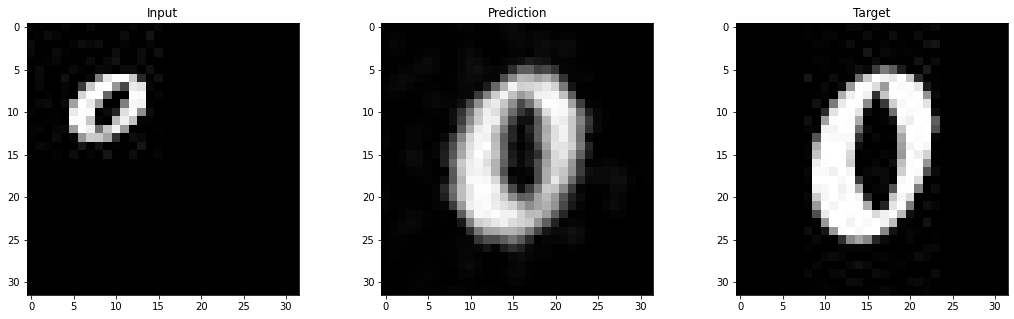

In [54]:
evaluate_model(model5, train_loader5, device)

In [86]:
# parameters
RANDOM_SEED = 410
LEARNING_RATE = 0.0002
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im6_in_path = 'images/sc_rot_tr/zero_centered'
im6_out_path = 'images/sc_rot_tr/zero_tf'
im6_in, im6_out = get_data(img_in_path=im6_in_path, img_out_path=im6_out_path)

train_loader6 = DataLoader(dataset=CustomTestDataset(im6_in, im6_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [87]:
torch.manual_seed(RANDOM_SEED)
model6 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=LEARNING_RATE)
criterion6 = nn.MSELoss(reduction="mean")

model6, optimizer6, _ = training_loop(model6, criterion6, optimizer6, train_loader6, N_EPOCHS, device, print_every=30)

12:14:16 --- Epoch: 29	Train loss: 0.1449
12:14:17 --- Epoch: 59	Train loss: 0.1404
12:14:17 --- Epoch: 89	Train loss: 0.1226
12:14:17 --- Epoch: 119	Train loss: 0.0923
12:14:18 --- Epoch: 149	Train loss: 0.0764
12:14:18 --- Epoch: 179	Train loss: 0.0573
12:14:19 --- Epoch: 209	Train loss: 0.0384
12:14:19 --- Epoch: 239	Train loss: 0.0234
12:14:19 --- Epoch: 269	Train loss: 0.0169
12:14:20 --- Epoch: 299	Train loss: 0.0151
12:14:20 --- Epoch: 329	Train loss: 0.0144
12:14:20 --- Epoch: 359	Train loss: 0.0121
12:14:21 --- Epoch: 389	Train loss: 0.0102
12:14:21 --- Epoch: 419	Train loss: 0.0079
12:14:21 --- Epoch: 449	Train loss: 0.0064
12:14:22 --- Epoch: 479	Train loss: 0.0054
12:14:22 --- Epoch: 509	Train loss: 0.0050
12:14:22 --- Epoch: 539	Train loss: 0.0048
12:14:23 --- Epoch: 569	Train loss: 0.0048
12:14:23 --- Epoch: 599	Train loss: 0.0047
12:14:23 --- Epoch: 629	Train loss: 0.0046
12:14:24 --- Epoch: 659	Train loss: 0.0046
12:14:24 --- Epoch: 689	Train loss: 0.0046
12:14:25 --- E

Proposed transformation Params:
-Scale: tensor([[1.9214]], device='cuda:0')
-Theta: tensor([[-0.4477]], device='cuda:0')
-Trans_x: tensor([[0.9986]], device='cuda:0')
-Trans_y: tensor([[0.2861]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


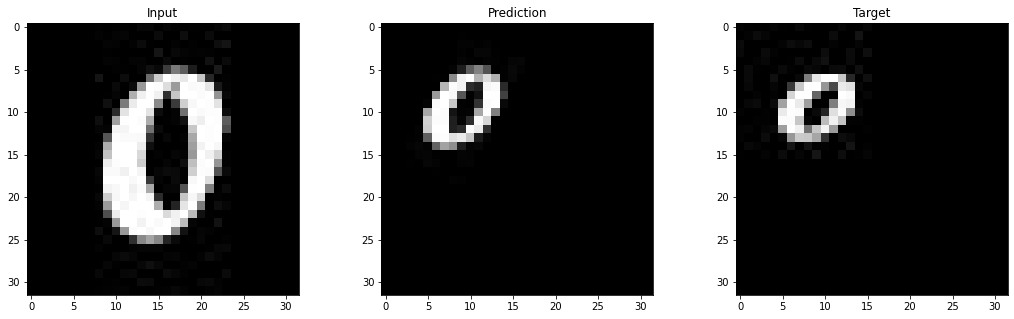

In [88]:
evaluate_model(model6, train_loader6, device)

In [126]:
# parameters
RANDOM_SEED = 415
LEARNING_RATE = 0.0005
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im7_in_path = 'images/sc_rot_tr/three_centered'
im7_out_path = 'images/sc_rot_tr/three_tf'
im7_in, im7_out = get_data(img_in_path=im7_in_path, img_out_path=im7_out_path)

train_loader7 = DataLoader(dataset=CustomTestDataset(im7_in, im7_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [127]:
torch.manual_seed(RANDOM_SEED)
model7 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer7 = torch.optim.Adam(model7.parameters(), lr=LEARNING_RATE)
criterion7 = nn.MSELoss(reduction="mean")

model7, optimizer7, _ = training_loop(model7, criterion7, optimizer7, train_loader7, N_EPOCHS, device, print_every=30)

12:25:33 --- Epoch: 29	Train loss: 0.1782
12:25:33 --- Epoch: 59	Train loss: 0.0976
12:25:33 --- Epoch: 89	Train loss: 0.0684
12:25:34 --- Epoch: 119	Train loss: 0.0659
12:25:34 --- Epoch: 149	Train loss: 0.0650
12:25:35 --- Epoch: 179	Train loss: 0.0648
12:25:35 --- Epoch: 209	Train loss: 0.0647
12:25:35 --- Epoch: 239	Train loss: 0.0648
12:25:36 --- Epoch: 269	Train loss: 0.0648
12:25:36 --- Epoch: 299	Train loss: 0.0624
12:25:37 --- Epoch: 329	Train loss: 0.0600
12:25:37 --- Epoch: 359	Train loss: 0.0322
12:25:37 --- Epoch: 389	Train loss: 0.0301
12:25:38 --- Epoch: 419	Train loss: 0.0298
12:25:38 --- Epoch: 449	Train loss: 0.0299
12:25:39 --- Epoch: 479	Train loss: 0.0299
12:25:39 --- Epoch: 509	Train loss: 0.0299
12:25:39 --- Epoch: 539	Train loss: 0.0298
12:25:40 --- Epoch: 569	Train loss: 0.0299
12:25:40 --- Epoch: 599	Train loss: 0.0300
12:25:41 --- Epoch: 629	Train loss: 0.0300
12:25:41 --- Epoch: 659	Train loss: 0.0299
12:25:41 --- Epoch: 689	Train loss: 0.0298
12:25:42 --- E

Proposed transformation Params:
-Scale: tensor([[1.7701]], device='cuda:0')
-Theta: tensor([[-0.7084]], device='cuda:0')
-Trans_x: tensor([[-0.1766]], device='cuda:0')
-Trans_y: tensor([[0.9379]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


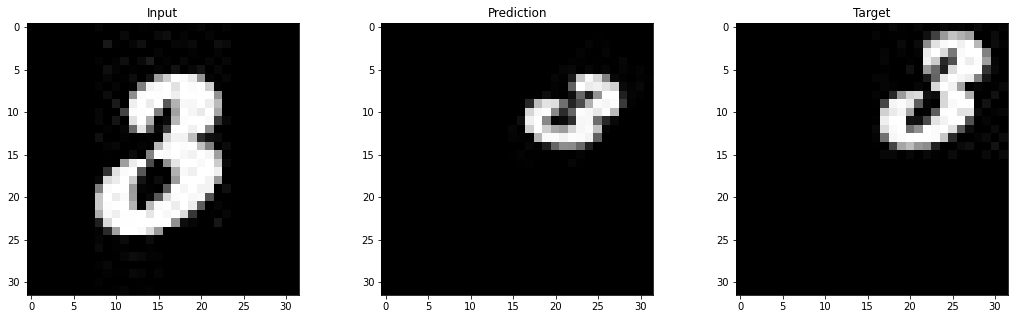

In [128]:
evaluate_model(model7, train_loader7, device)

In [146]:
# parameters
RANDOM_SEED = 415
LEARNING_RATE = 0.05
BATCH_SIZE = 1
N_EPOCHS = 900
IMG_SIZE = 32

im8_in_path = 'images/sc_rot_tr/three_tf'
im8_out_path = 'images/sc_rot_tr/three_centered'
im8_in, im8_out = get_data(img_in_path=im8_in_path, img_out_path=im8_out_path)

train_loader8 = DataLoader(dataset=CustomTestDataset(im8_in, im8_out), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [147]:
torch.manual_seed(RANDOM_SEED)
model8 = AttentionTransformation(device,IMG_SIZE).to(device)
optimizer8 = torch.optim.Adam(model8.parameters(), lr=LEARNING_RATE)
criterion8 = nn.MSELoss(reduction="mean")

model8, optimizer8, _ = training_loop(model8, criterion8, optimizer8, train_loader8, N_EPOCHS, device, print_every=30)

12:29:16 --- Epoch: 29	Train loss: 0.0118
12:29:17 --- Epoch: 59	Train loss: 0.0094
12:29:17 --- Epoch: 89	Train loss: 0.0093
12:29:18 --- Epoch: 119	Train loss: 0.0093
12:29:18 --- Epoch: 149	Train loss: 0.0093
12:29:19 --- Epoch: 179	Train loss: 0.0093
12:29:19 --- Epoch: 209	Train loss: 0.0093
12:29:19 --- Epoch: 239	Train loss: 0.0093
12:29:20 --- Epoch: 269	Train loss: 0.0093
12:29:20 --- Epoch: 299	Train loss: 0.0093
12:29:21 --- Epoch: 329	Train loss: 0.0093
12:29:21 --- Epoch: 359	Train loss: 0.0093
12:29:22 --- Epoch: 389	Train loss: 0.0093
12:29:22 --- Epoch: 419	Train loss: 0.0094
12:29:22 --- Epoch: 449	Train loss: 0.0093
12:29:23 --- Epoch: 479	Train loss: 0.0093
12:29:23 --- Epoch: 509	Train loss: 0.0093
12:29:24 --- Epoch: 539	Train loss: 0.0093
12:29:24 --- Epoch: 569	Train loss: 0.0093
12:29:25 --- Epoch: 599	Train loss: 0.0093
12:29:25 --- Epoch: 629	Train loss: 0.0093
12:29:25 --- Epoch: 659	Train loss: 0.0093
12:29:26 --- Epoch: 689	Train loss: 0.0093
12:29:26 --- E

Proposed transformation Params:
-Scale: tensor([[0.7473]], device='cuda:0')
-Theta: tensor([[0.2340]], device='cuda:0')
-Trans_x: tensor([[0.4725]], device='cuda:0')
-Trans_y: tensor([[-0.4735]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


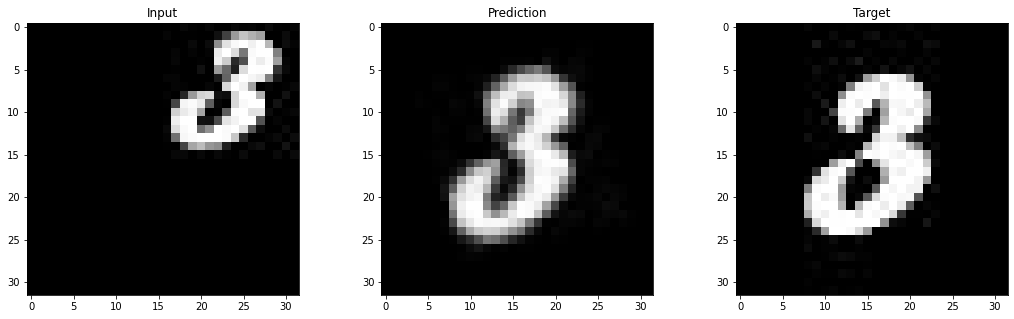

In [148]:
evaluate_model(model8, train_loader8, device)